# Attentional RNN Example

Now that we've seen how to implement an RNN, and shown how to train one in Keras, let's see something a bit newer; adding **attention**. Attention is an interesting concept that has started to become more popular in the neural network community recently, although there are several formulations of the concept. The paper [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](http://arxiv.org/abs/1502.03044) used a convolutional neural network to generate a neural encoding of an image, and a recurrent neural network to generate a sentence describing that network. The recurrent network was trained to pay attention to certain parts of the image. This resulted in really good descriptions of images, such as the ones below.

![Attention](images/attention.png)

## Let's use attention to solve a problem

Let's formulate another type of attention, where we train a language model to pay attention to certain words. This is just a dummy example, but hopefully it will illustrate the concept of "attention" a little bit.

The **problem** will be: Given a question and a sentence, determine if the question is true.

We will train a network to *read* the sentence, while paying attention to the question, in order to solve this problem.

In [1]:
from __future__ import print_function

template = 'the %s in the %s is in the %s'

sentences = [
    template % ('cat', 'hat', 'barn'),
    template % ('cat', 'hat', 'house'),
    template % ('cat', 'shoes', 'barn'),
    template % ('cat', 'shoes', 'house'),
    template % ('dog', 'hat', 'barn'),
    template % ('dog', 'hat', 'house'),
    template % ('dog', 'shoes', 'barn'),
    template % ('dog', 'shoes', 'house'),
]

print('\n'.join(sentences))

the cat in the hat is in the barn
the cat in the hat is in the house
the cat in the shoes is in the barn
the cat in the shoes is in the house
the dog in the hat is in the barn
the dog in the hat is in the house
the dog in the shoes is in the barn
the dog in the shoes is in the house


In [2]:
questions = {
    'is it wearing the hat?': [0, 1, 4, 5],
    'is it wearing the shoes?': [2, 3, 6, 7],
    'is it called the cat?': [0, 1, 2, 3],
    'is it called the dog?': [4, 5, 6, 7],
    'is it in the barn?': [0, 2, 4, 6],
    'is it in the house?': [1, 3, 5, 7],
}

for question, sentence_indices in questions.items():
    print(question)
    for index in sentence_indices:
        print(' -', sentences[index])

is it wearing the shoes?
 - the cat in the shoes is in the barn
 - the cat in the shoes is in the house
 - the dog in the shoes is in the barn
 - the dog in the shoes is in the house
is it called the dog?
 - the dog in the hat is in the barn
 - the dog in the hat is in the house
 - the dog in the shoes is in the barn
 - the dog in the shoes is in the house
is it called the cat?
 - the cat in the hat is in the barn
 - the cat in the hat is in the house
 - the cat in the shoes is in the barn
 - the cat in the shoes is in the house
is it in the barn?
 - the cat in the hat is in the barn
 - the cat in the shoes is in the barn
 - the dog in the hat is in the barn
 - the dog in the shoes is in the barn
is it wearing the hat?
 - the cat in the hat is in the barn
 - the cat in the hat is in the house
 - the dog in the hat is in the barn
 - the dog in the hat is in the house
is it in the house?
 - the cat in the hat is in the house
 - the cat in the shoes is in the house
 - the dog in the hat i

Now that we've got some training data, let's tokenize it and generate a vocabulary so that we convert each word to indices.

In [3]:
tokenize = lambda sentence: sentence.replace('?', '').lower().split(' ')
vocabulary = set()
for sentence in sentences:
    vocabulary = vocabulary.union(set(tokenize(sentence)))
for question in questions.keys():
    vocabulary = vocabulary.union(set(tokenize(question)))
vocabulary = list(vocabulary)

idx2word = dict([(i+1, word) for i, word in enumerate(vocabulary)])
word2idx = dict([(word, i+1) for i, word in enumerate(vocabulary)])

# add in the 'no word' marker at the zero'th index
idx2word[0] = '_'
word2idx['_'] = 0

print(word2idx)

{'wearing': 1, 'shoes': 2, 'house': 3, 'is': 4, 'dog': 5, 'cat': 6, 'in': 7, 'it': 8, 'the': 9, 'hat': 10, 'called': 11, '_': 0, 'barn': 12}


Now let's turn our data into Numpy arrays, where `X_question` and `X_sentence` will represent the encoded questions and sentences, and `y` will represent whether or not the question is true, as it pertains to that sentence.

In [4]:
import numpy as np
np.random.seed(42)

nb_samples = len(questions) * len(sentences)
max_length = 10

X_question, X_sentence, y = np.zeros((nb_samples, max_length)), np.zeros((nb_samples, max_length)), np.zeros((nb_samples,))

def encode(sentence):
    arr = np.zeros((max_length,))
    for i, v in enumerate(tokenize(sentence)):
        arr[i] = word2idx[v]
    return arr

def decode(arr):
    return ' '.join([idx2word[i] for i in arr if i != 0])

i = 0
for question, keys in questions.items():
    for j, sentence in enumerate(sentences):
        X_question[i, :] = encode(question)
        X_sentence[i, :] = encode(sentence)
        y[i] = 1 if j in keys else 0
        i += 1

print('Question:', questions.keys()[0])
print('Encoded:', X_question[0, :])
print('Decoded:', decode(X_question[0, :]), end='\n\n')

print('Number of questions:', nb_samples)
print('X_question shape: {}, X_sentence shape: {}, y shape: {}'.format(X_question.shape, X_sentence.shape, y.shape))

Question: is it wearing the shoes?
Encoded: [ 4.  8.  1.  9.  2.  0.  0.  0.  0.  0.]
Decoded: is it wearing the shoes

Number of questions: 48
X_question shape: (48, 10), X_sentence shape: (48, 10), y shape: (48,)


## Adding Attention to a Keras LSTM

Now that we've got our data all set up, let's actually build the model. The equations for our attentional LSTM are outlined in [this paper](http://arxiv.org/pdf/1511.04108.pdf):

```
input_gate = tanh(dot(input_vector, W_input) + dot(prev_hidden, U_input) + b_input)
forget_gate = tanh(dot(input_vector, W_forget) + dot(prev_hidden, U_forget) + b_forget)
output_gate = tanh(dot(input_vector, W_output) + dot(prev_hidden, U_output) + b_output)

candidate_state = tanh(dot(input_vector, W_hidden) + dot(prev_hidden, U_hidden) + b_hidden)
memory_unit = prev_candidate_state * forget_gate + candidate_state * input_gate

new_hidden_state = tanh(memory_unit) * output_gate

attention_state = tanh(dot(attention_vec, W_attn) + dot(new_hidden_state, U_attn))
attention_param = exp(dot(attention_state, W_param))
new_hidden_state = new_hidden_state * attention_param
```

However, the only **new** parts are the last three equations:

```
attention_state = tanh(dot(attention_vec, W_attn) + dot(new_hidden_state, U_attn))
attention_param = exp(dot(attention_state, W_param))
new_hidden_state = new_hidden_state * attention_param
```

![Attentional LSTM](images/attention_lstm.png)We would really like to reuse the Keras LSTM code while adding on our attentional component. To do this, we create a wrapper. The code for this is pretty involved, but I dumped it all down here.

In [5]:
from keras import backend as K
from keras.engine import InputSpec
from keras.layers import LSTM, activations, Wrapper

class AttentionLSTMWrapper(Wrapper):
    '''Wrapper for an LSTM to make it pay attention to an encoded vector.
    
    layer: the layer to wrap
    attention_vec: the vector to pay attention to
    attn_activation: a parameter of the attentional component.
    '''
    def __init__(self, layer, attention_vec, attn_activation='sigmoid', single_attention_param=False, **kwargs):
        assert isinstance(layer, LSTM)
        self.supports_masking = True
        self.attention_vec = attention_vec
        self.attn_activation = activations.get(attn_activation)
        self.single_attention_param = single_attention_param
        super(AttentionLSTMWrapper, self).__init__(layer, **kwargs)

    def build(self, input_shape):
        assert len(input_shape) >= 3
        self.input_spec = [InputSpec(shape=input_shape)]

        if not self.layer.built:
            self.layer.build(input_shape)
            self.layer.built = True

        super(AttentionLSTMWrapper, self).build()

        if hasattr(self.attention_vec, '_keras_shape'):
            attention_dim = self.attention_vec._keras_shape[1]
        else:
            raise Exception('Layer could not be build: No information about expected input shape.')

        self.U_a = self.layer.inner_init((self.layer.output_dim, self.layer.output_dim), name='{}_U_a'.format(self.name))
        self.b_a = K.zeros((self.layer.output_dim,), name='{}_b_a'.format(self.name))

        self.U_m = self.layer.inner_init((attention_dim, self.layer.output_dim), name='{}_U_m'.format(self.name))
        self.b_m = K.zeros((self.layer.output_dim,), name='{}_b_m'.format(self.name))

        if self.single_attention_param:
            self.U_s = self.layer.inner_init((self.layer.output_dim, 1), name='{}_U_s'.format(self.name))
            self.b_s = K.zeros((1,), name='{}_b_s'.format(self.name))
        else:
            self.U_s = self.layer.inner_init((self.layer.output_dim, self.layer.output_dim), name='{}_U_s'.format(self.name))
            self.b_s = K.zeros((self.layer.output_dim,), name='{}_b_s'.format(self.name))

        self.trainable_weights = [self.U_a, self.U_m, self.U_s, self.b_a, self.b_m, self.b_s]

    def get_output_shape_for(self, input_shape):
        return self.layer.get_output_shape_for(input_shape)

    def step(self, x, states, return_attn=False):
        h, [h, c] = self.layer.step(x, states)
        attention = states[4]

        m = self.attn_activation(K.dot(h, self.U_a) * attention + self.b_a)
        s = K.sigmoid(K.dot(m, self.U_s) + self.b_s)

        if self.single_attention_param:
            h = h * K.repeat_elements(s, self.layer.output_dim, axis=1)
        else:
            h = h * s
        
        if return_attn:
            return s, [h, c, s]
        else:
            return h, [h, c, s]

    def get_constants(self, x):
        constants = self.layer.get_constants(x)
        constants.append(K.dot(self.attention_vec, self.U_m) + self.b_m)
        return constants

    def call(self, x, mask=None):
        # input shape: (nb_samples, time (padded with zeros), input_dim)
        # note that the .build() method of subclasses MUST define
        # self.input_spec with a complete input shape.
        input_shape = self.input_spec[0].shape
        if K._BACKEND == 'tensorflow':
            if not input_shape[1]:
                raise Exception('When using TensorFlow, you should define '
                                'explicitly the number of timesteps of '
                                'your sequences.\n'
                                'If your first layer is an Embedding, '
                                'make sure to pass it an "input_length" '
                                'argument. Otherwise, make sure '
                                'the first layer has '
                                'an "input_shape" or "batch_input_shape" '
                                'argument, including the time axis. '
                                'Found input shape at layer ' + self.name +
                                ': ' + str(input_shape))
        if self.layer.stateful:
            initial_states = self.layer.states
        else:
            initial_states = self.layer.get_initial_states(x) + [None]
        constants = self.get_constants(x)
        preprocessed_input = self.layer.preprocess_input(x)

        last_output, outputs, states = K.rnn(lambda x, states: self.step(x, states, False),
                                             preprocessed_input,
                                             initial_states,
                                             go_backwards=self.layer.go_backwards,
                                             mask=mask,
                                             constants=constants,
                                             unroll=self.layer.unroll,
                                             input_length=input_shape[1])
        
        last_output_attn, outputs_attn, states_attn = K.rnn(lambda x, states: self.step(x, states, True),
                                             preprocessed_input,
                                             initial_states,
                                             go_backwards=self.layer.go_backwards,
                                             mask=mask,
                                             constants=constants,
                                             unroll=self.layer.unroll,
                                             input_length=input_shape[1])
        
        self.attention_param = outputs_attn
        
        if self.layer.stateful:
            self.updates = []
            for i in range(len(states)):
                self.updates.append((self.layer.states[i], states[i]))

        if self.layer.return_sequences:
            return outputs
        else:
            return last_output

Using Theano backend.


Awesome, now we're ready to put it together. We use one LSTM to generate an encoding of the question, then we wrap that LSTM with our attentional wrapper, using the question encoding at the attentional component.

In [6]:
# the variables representing the input to the model
from keras.layers import Input, Lambda
question = Input(shape=(max_length,), dtype='int32')
sentence = Input(shape=(max_length,), dtype='int32')

# embed each word into an n-dimensional space
from keras.layers import Embedding
embedding = Embedding(input_dim=len(word2idx), output_dim=10)
question_embedded, sentence_embedded = embedding(question), embedding(sentence)

# use an LSTM to transform the question
maxpool = Lambda(lambda x: K.max(x, axis=1, keepdims=False), output_shape=lambda x: (x[0], x[2]))
encoder = LSTM(output_dim=10, return_sequences=True, inner_activation='sigmoid', activation='sigmoid')
question_encoded = maxpool(encoder(question_embedded))

# wrap the encoder with attention to the question
encoder_wrapped = AttentionLSTMWrapper(encoder, question_encoded, single_attention_param=True)
sentence_encoded = maxpool(encoder_wrapped(sentence_embedded))

# similarity
from keras.layers import Dropout, merge
dot = lambda a, b: K.batch_dot(a, b, axes=1)
similarity = lambda x: dot(x[0], x[1]) / K.maximum(K.sqrt(dot(x[0], x[0]) * dot(x[1], x[1])), K.epsilon())
margin = lambda x: 5 * K.relu(similarity(x) - 0.8)
similarity = merge([question_encoded, sentence_encoded], mode=margin, output_shape=lambda _: (None, 1))

# build our model
from keras.models import Model
from keras.optimizers import RMSprop
model = Model(input=[question, sentence], output=[similarity])
model.compile(optimizer=RMSprop(lr=0.001), loss='mse')

print('Input shape: {}, output shape: {}'.format(model.input_shape, model.output_shape))

Input shape: [(None, 10), (None, 10)], output shape: (None, 1)


Now that we've got our model and our data, we're ready to start training!

In [7]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999; // turn off autoscrolling

<IPython.core.display.Javascript object>

In [8]:
# repeat the data a bunch
nb_batches = 1000
X_question_data = np.tile(X_question, [nb_batches, 1])
X_sentence_data = np.tile(X_sentence, [nb_batches, 1])
y_data = np.tile(y, [nb_batches,])

from keras.callbacks import Callback
class ThresholdStop(Callback):
    def __init__(self, threshold, monitor='loss'):
        super(ThresholdStop, self).__init__()
        self.threshold = threshold
        self.monitor = monitor

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn('Early stopping requires %s available!' %
                          (self.monitor), RuntimeWarning)
        if np.less(current, self.threshold):
            self.model.stop_training = True

# y_pred = model.predict([X_question, X_sentence])
# print(np.concatenate([y_pred, np.reshape(y, (len(y_pred), 1))], axis=1))

print('Error before: {}'.format(model.evaluate([X_question, X_sentence], [y], verbose=0)))
history = model.fit([X_question_data, X_sentence_data], [y_data], batch_size=X_question.shape[0], nb_epoch=10,
                    callbacks=[ThresholdStop(1e-5)])
print('Error after: {}'.format(model.evaluate([X_question, X_sentence], [y], verbose=0)))

Error before: 0.493862827619
Epoch 1/10
48000/48000 [==============================] - 7s - loss: 0.2090     
Epoch 2/10
48000/48000 [==============================] - 8s - loss: 0.1329     
Epoch 3/10
48000/48000 [==============================] - 8s - loss: 0.0936     
Epoch 4/10
48000/48000 [==============================] - 11s - loss: 0.0853    
Epoch 5/10
48000/48000 [==============================] - 14s - loss: 0.0573    
Epoch 6/10
48000/48000 [==============================] - 12s - loss: 7.8492e-04    
Epoch 7/10
48000/48000 [==============================] - 13s - loss: 6.9241e-08    
Error after: 7.02222073083e-09


We can plot the loss over time using the code below.

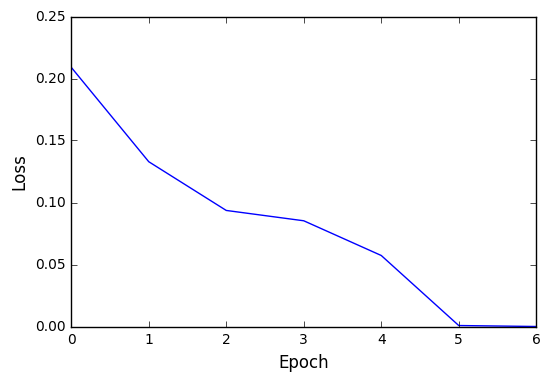

In [9]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'])
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.show()

## Interpretting the attentional parameters

Now that we've got a trained model, let's try to visualize how the attentional code works.

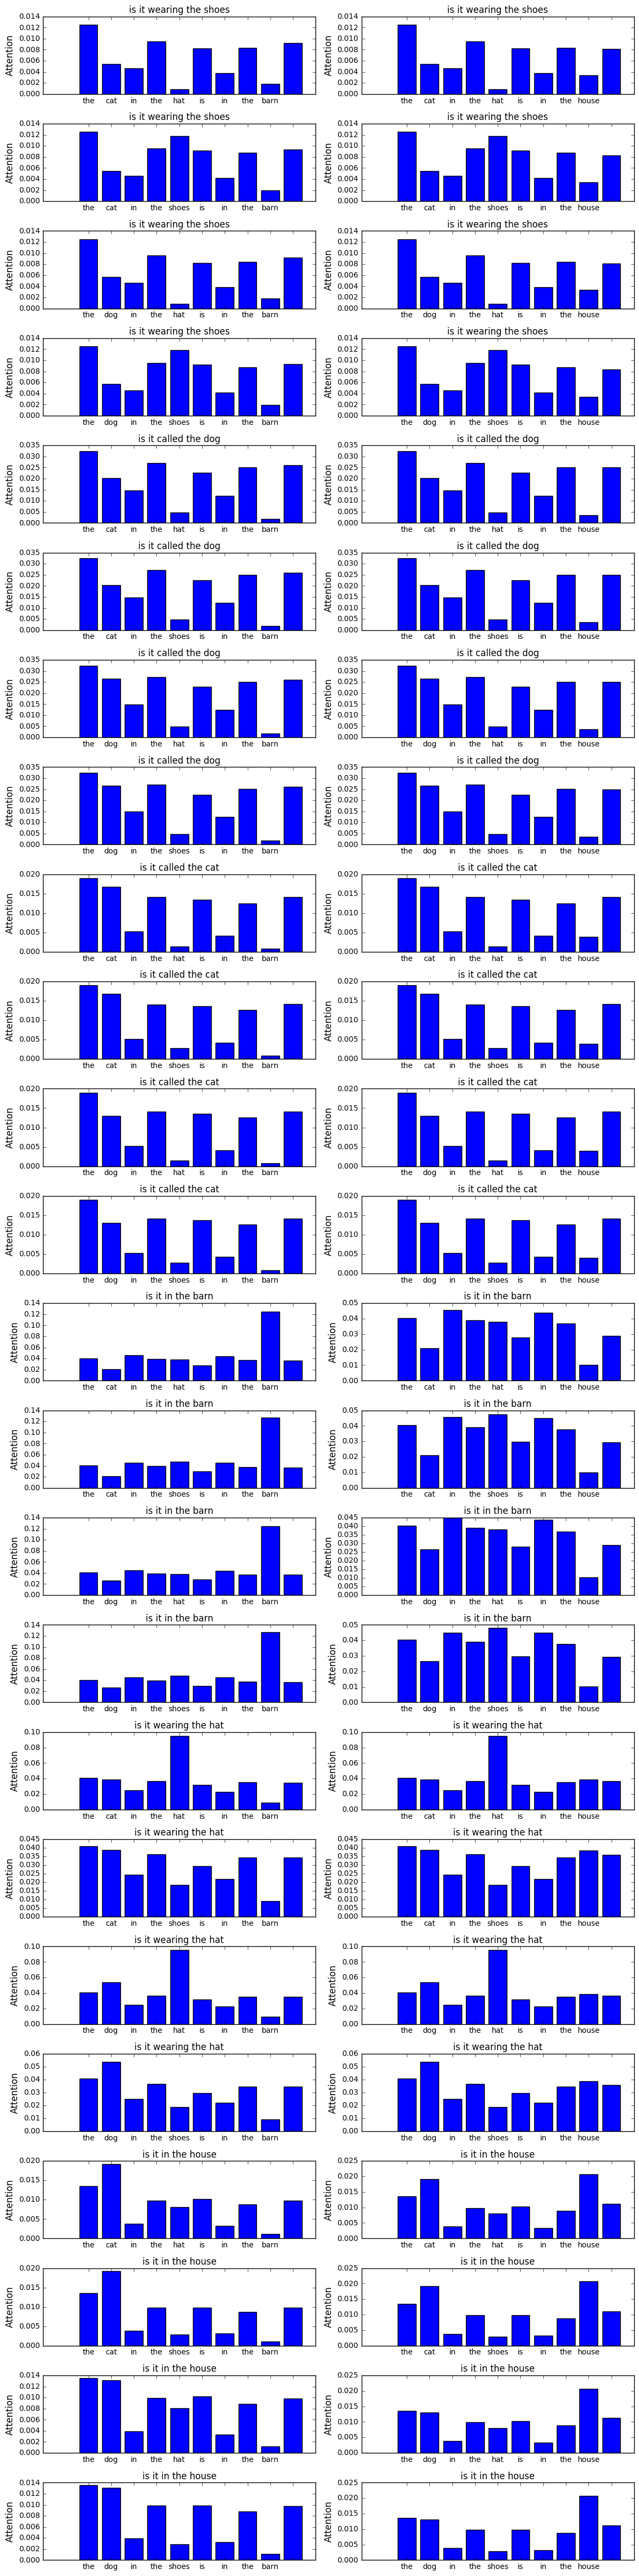

In [10]:
attention_func = K.function([question, sentence, K.learning_phase()], [encoder_wrapped.attention_param])
attention = attention_func([X_question, X_sentence, 0])[0]

n_display = len(attention)

plt.figure(figsize=(12, 2 * n_display / 2))
for i in range(n_display):
    plt.subplot(n_display / 2, 2, i+1)
    plt.bar(range(len(attention[i])), attention[i], align='center')
    plt.xticks(range(len(attention[i])), tokenize(decode(X_sentence[i])), rotation='horizontal')
    plt.title(decode(X_question[i]), fontsize=12)
    plt.ylabel('Attention', fontsize=12)
plt.tight_layout()
plt.show()

These results are interesting. Sometimes the attention mechanism appears to be highlighting the relevant word (which is the desired behavior), while other times it doesn't. There are various reasons why, and it depends a lot on the way that the model is formulated. However, it shows that the attention mechanism is a useful way to solve these types of problems.